In [1]:
%%capture
!pip install tensorflow-datasets==4.8 --quiet
!pip install tensorflow==2.15.0 --quiet #15 13
!pip install tf_keras==2.15.0 --quiet
!pip install tensorflow-text==2.15.0 --quiet #15
!pip install pydot --quiet
!pip install transformers==4.17 --quiet
!pip install -U scikit-learn

In [2]:
#Tensorflow libiries
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds

#Transformers - BERT from huggingface
from transformers import BertTokenizer, TFBertModel
from transformers import AutoTokenizer, TFAutoModel
from transformers import logging
logging.set_verbosity_error()
from transformers import AutoConfig
from tensorflow.keras.callbacks import EarlyStopping

#NLP libiries
import sklearn as sk
from sklearn.metrics import classification_report
import os
import nltk
from nltk.data import find

#data process
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing
import pandas as pd
import math
from bs4 import BeautifulSoup
import os
import json


In [15]:
#loading the pre-trained tokenizer and model
distillroberta_nli_tokenizer = AutoTokenizer.from_pretrained('matekadlicsko/distilroberta-nli')
distillroberta_nli_model = TFAutoModel.from_pretrained('matekadlicsko/distilroberta-nli', from_pt=True)

In [6]:
#load the dataset with error handling
try:
    train_df = pd.read_csv('full_train_data(Revised).csv')
except pd.errors.ParserError as e:
    print(f"Error reading CSV: {e}")
    # Print the lines around the problematic row
    with open('full_train_data(Revised).csv', 'r') as f:
        lines = f.readlines()
        for i in range(17622, 17626):
            if i < len(lines):
                print(lines[i])

test_df = pd.read_csv('full_test_data(Revised).csv')

# Adjust pandas display settings to show all rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Show full content of each column
pd.set_option('display.width', None)  # Auto-detect width of the display




In [7]:
train_df.head(1)

,title,date,content_original,bias,bias_text,source
0,"carly fiorina squanders momentum, slip republican debate?s main stage",2016-01-13,"carly fiorina remains beloved eye many gop voter squandered momentum earned shining debate performance last summer, limp new year hoping lastminute miracle presidential primary. after clawed way onto main stage debate september, sole woman republican field relegated second tier thursday’s debate south carolina. the fiorina camp downplaying snub, insisting there’s still time sway huge swath primary voter say haven’t firmly committed candidate. poll don’t decide elections, neither medium executives. voter do,” anna epstein, campaign spokesperson, said. voter frustrated political class failed year year. carly win job, carly job.” but voter beginning question viability failed capitalize early good fortune. during appearance week cbs radio boston, supporter called ask mrs. fiorina polling posed question candidate want hear: would willing accept running mate rivals? i running president,” mrs. fiorina responded blunt fashion. leader.” the interaction came shortly fox business network announced monday mrs. fiorina sen. rand paul kentucky missed cut 9 p.m. primetime debate north charleston. instead, duo invited participate 6 p.m. undercard debate former pennsylvania sen. rick santorum former arkansas gov. mike huckabee, past two winner iowa caucuses. mr. paul plan skip event protest, mrs. fiorina. charlie gerow, adviser mrs. fiorina, said earlier forum provide another opportunity shine. carly fiorina always exceptionally well debate stage, proven beyond shadow doubt kind candidate is, thursday night give yet another opportunity visibly demonstrate credential capability commander chief,” mr. gerow said. donald trump, meanwhile, poised take center stage primetime forum, sandwiched sens. ted cruz texas marco rubio florida. flanking trio retired neurosurgeon ben carson former florida gov. jeb bush one side new jersey gov. chris christie ohio gov. john kasich other. mrs. fiorina’s slide come despite tallying 100 day campaigning iowa new hampshire — competitor — according tally democracy action. some blame struggle early decision outsource good chunk traditional campaign operation supportive super political action committee, leaving mrs. fiorina without campaign infrastructure capitalize relentless campaigning. also sense outsider” message grown stale. still, others baffled. i’ve seen her, fantastic,” said brian murphy, chairman rockingham county gop new hampshire. think offer lot substance short stump speech. can’t understand people interested topthree choice.” fergus cullen, former new hampshire gop chairman, said mrs. fiorina struggled get voter commit — much like others field. it bit mystery,” mr. cullen said mrs. fiorina’s standing race. sure get candidate time get candid, express frustration: ‘what to convert someone considering committed supporter?’” mrs. fiorina’s high point race far came wake memorable backtoback debate performance cleveland california, cast hillary clinton’s kryptonite. said outsider business acumen worldly knowledge needed political class” could not: bolster economy nation’s image world stage. mrs. fiorina also something done: got better exchange donald trump comment made looks. but added attention came increased scrutiny political past republican party official failed 2010 senate candidate california. critic also attacked professional record ceo hewlettpackard. since then, faded polls, realclearpolitics.com average poll show running ninth iowa eighth new hampshire. maybe would gotten constituency going donald trump wasn’t there,” said rogers, chairman polk county gop iowa. one hand, talk ceo, donald trump make claim well. maybe strength overshadowed candidates.” sign daily newsletter copyright © 2019 washington times, llc. click reprint permission.",2,right,Washington Times


In [8]:
print(f"basic train_df info: ",train_df.shape)

basic train_df info:  (20114, 6)


In [9]:
test_df.head(1)

title        date  \
0  president obamas supreme court shortlist leaked. 6 contenders.  2016-03-12   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [10]:
print(f"basic test_df info: ",test_df.shape)

basic test_df info:  (5029, 6)


In [11]:
# extract the train and test text from both dataframes
train_text = train_df['content_original']
train_text_labels = train_df['bias']

validate_text = test_df['content_original'][0:2000]
validate_text_labels = test_df['bias'][0:2000]

test_text = test_df['content_original'][2000:]
test_text_labels = test_df['bias'][2000:]


print(f"size of training dataset: ",len(train_text))
print()
print(f"size of valid dataset: ",len(validate_text))
print()
print(f"size of testing dataset: ",len(test_text))
print()
print(f"Left with Label 0 ")
print(f"Center with Label 1 ")
print(f"Right with Label 2 ")

size of training dataset:  20114

size of valid dataset:  2000

size of testing dataset:  3029

Left with Label 0 
Center with Label 1 
Right with Label 2 


In [12]:
MAX_SEQUENCE_LENGTH = 512

In [17]:
# tokenize the dataset, truncate at `max_length`,

#tokenizing the train text
x_train = distillroberta_nli_tokenizer(train_text.tolist(),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_train = train_text_labels

#tokenizing the validate text
x_validate = distillroberta_nli_tokenizer(validate_text.tolist(),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_validate = validate_text_labels


#tokenizing the test text
x_test = distillroberta_nli_tokenizer(test_text.tolist(),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_test = test_text_labels

In [18]:
#BERT base uncased model configurations
config = AutoConfig.from_pretrained('matekadlicsko/distilroberta-nli')

config

RobertaConfig {
  "_name_or_path": "matekadlicsko/distilroberta-nli",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.17.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

#BERT Uncase Model Fine-Tuning

In [51]:
def create_distillroberta_nli_classification_model(roberta_model,
                                     num_train_layers=6,
                                     num_classes = 3,
                                     hidden_size = 768,
                                     dropout=0.3,
                                     attention_probs_dropout_prob = 0.2,
                                     hidden_dropout_prob=0.25,
                                     learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes
    """
    if num_train_layers == 0:
        # Freeze all layers of pre-trained BERT model
        roberta_model.trainable = False

    elif num_train_layers == 12:
        # Train all layers of the BERT model
        roberta_model.trainable = True

    else:
        # Restrict training to the num_train_layers outer transformer layers
        retrain_layers = []

        for retrain_layer_number in range(num_train_layers):

            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)


        print('retrain layers: ', retrain_layers)

        for w in roberta_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                #print('freezing: ', w)
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    #token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    roberta_inputs = {'input_ids': input_ids,
                   #'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    roberta_out = roberta_model(roberta_inputs)

    #pooler_token = bert_out[1]
    cls_output = roberta_out[0][:, 0, :]
    dropout_output = keras.layers.Dropout(0.3)(cls_output)


    classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(dropout_output)

    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model

In [52]:
#let's get a fresh instance of the bert_model -- good practice
distillroberta_nli_model = TFBertModel.from_pretrained('matekadlicsko/distilroberta-nli', from_pt=True)
distillroberta_nli_classification_model = create_distillroberta_nli_classification_model(distillroberta_nli_model, num_train_layers=6)

retrain layers:  ['_11', '_10', '_9', '_8', '_7', '_6']


In [45]:
#layer summary
distillroberta_nli_classification_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 512)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 512)]                0         []                            
 r)                                                                                               
                                                                                                  
 tf_bert_model_5 (TFBertMod  TFBaseModelOutputWithPooli   8211840   ['attention_mask_layer[0][0]',
 el)                         ngAndCrossAttentions(last_   0          'input_ids_layer[0][0]'

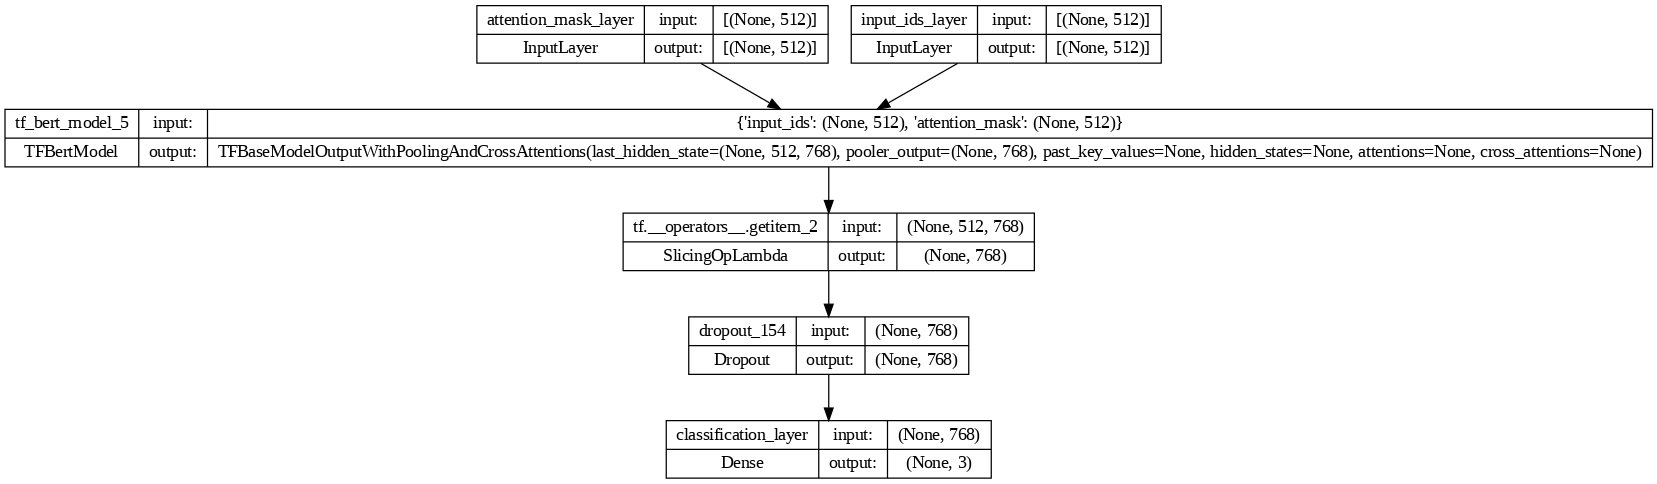

In [46]:
keras.utils.plot_model(distillroberta_nli_classification_model, show_shapes=True, dpi=90)

In [47]:
from tensorflow.keras.callbacks import EarlyStopping
# Early stopping callback to avoid overfitting issue
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=1,
    mode='max',
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [53]:
distillroberta_nli_classification_model_history = distillroberta_nli_classification_model.fit(
    [x_train.input_ids, x_train.attention_mask],
    y_train,
    validation_data=([x_validate.input_ids, x_validate.attention_mask], y_validate),
    batch_size=32,
    epochs=4,
    callbacks=[early_stopping]
)

Epoch 1/4


629/629 [==============================] - 288s 426ms/step - loss: 1.1334 - accuracy: 0.4423 - val_loss: 0.6281 - val_accuracy: 0.7070
Epoch 2/4
629/629 [==============================] - 266s 422ms/step - loss: 0.5430 - accuracy: 0.7674 - val_loss: 0.4533 - val_accuracy: 0.8255
Epoch 3/4
629/629 [==============================] - 266s 423ms/step - loss: 0.3501 - accuracy: 0.8700 - val_loss: 0.4140 - val_accuracy: 0.8595
Epoch 4/4
629/629 [==============================] - 266s 423ms/step - loss: 0.1843 - accuracy: 0.9370 - val_loss: 0.5347 - val_accuracy: 0.8325


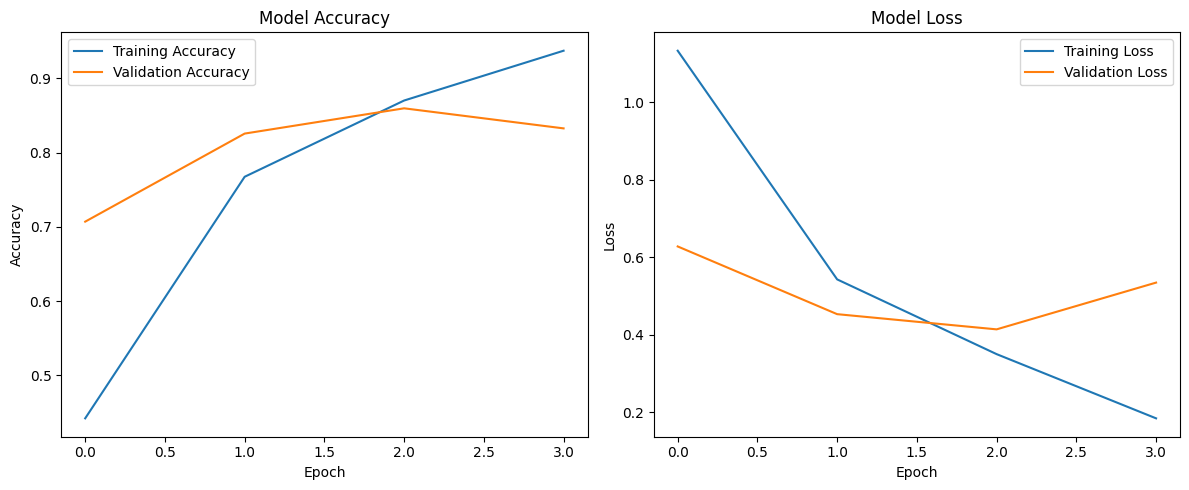

In [55]:
history = distillroberta_nli_classification_model_history.history

# Plotting accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1,2,2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [57]:
#Fine-Tuned BERT model overall prediction score
score = distillroberta_nli_classification_model.evaluate([x_test.input_ids, x_test.attention_mask],
                                                  y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

95/95 [==============================] - 13s 136ms/step - loss: 0.4234 - accuracy: 0.8495
Test loss: 0.42343366146087646
Test accuracy: 0.8494552373886108


In [58]:
predictions_model= distillroberta_nli_classification_model.predict([x_test.input_ids, x_test.attention_mask])
predictions_model = tf.argmax(predictions_model, axis=-1)
predictions_model

95/95 [==============================] - 14s 132ms/step


<tf.Tensor: shape=(3029,), dtype=int64, numpy=array([1, 1, 2, ..., 2, 2, 0])>

In [59]:
print(classification_report(y_test, predictions_model.numpy(),
                            target_names=['Left ','Center','Right']))

              precision    recall  f1-score   support

       Left        0.88      0.83      0.85      1263
      Center       0.93      0.82      0.87       688
       Right       0.78      0.89      0.83      1078

    accuracy                           0.85      3029
   macro avg       0.86      0.85      0.85      3029
weighted avg       0.86      0.85      0.85      3029



In [60]:
def plot_confusion_matrix(y_true, y_pred, label_names):
    cm = tf.math.confusion_matrix(y_true, y_pred)
    cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

    plt.figure(figsize=(20,7))
    sns.heatmap(
        cm, annot=True,
        xticklabels=label_names,
        yticklabels=label_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")

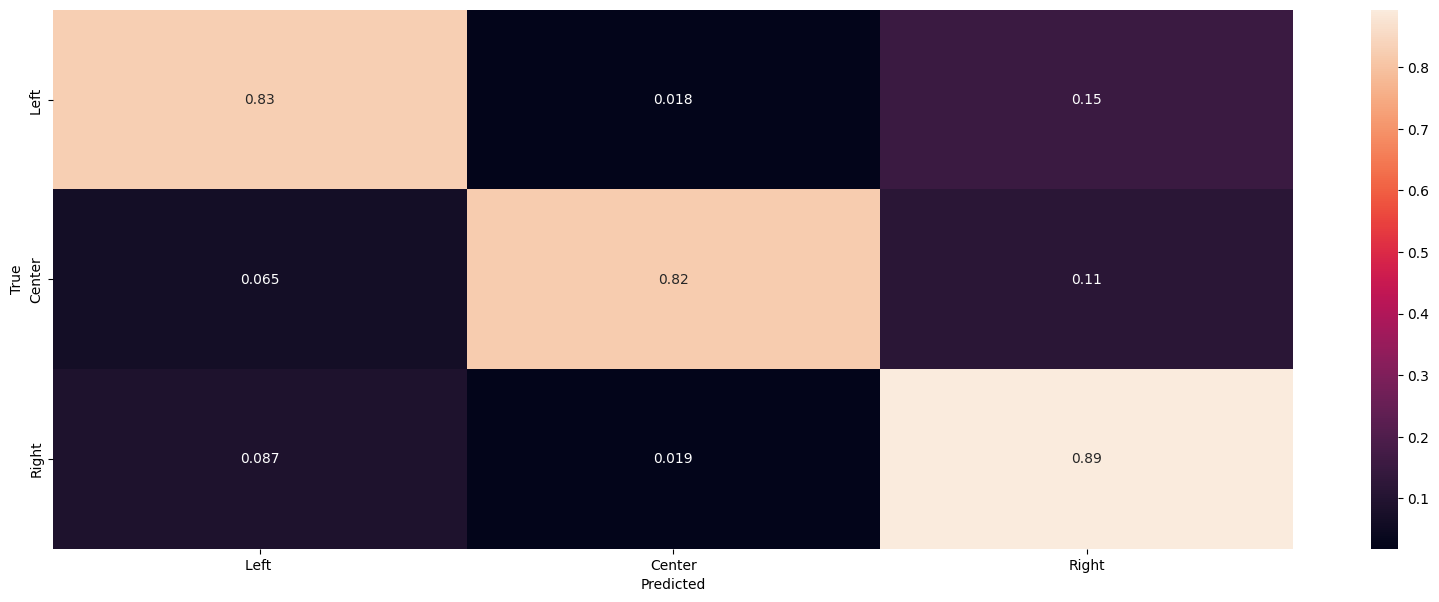

In [61]:
target_names=['Left ','Center','Right']
plot_confusion_matrix(y_test, predictions_model.numpy(), target_names)

In [62]:
roberta_wrong_guesses = np.where(y_test != predictions_model.numpy())

In [63]:
print(f'Number of Wrong Guesses: ',len(roberta_wrong_guesses[0]))

Number of Wrong Guesses:  456


In [65]:
#sampling 20 of the wrong precditions
wrong_guesses = [i for i in np.squeeze(roberta_wrong_guesses[0])]
decoded_wrong_guesses_text=[]

for i in wrong_guesses[:]:
  decoded_text = distillroberta_nli_tokenizer.decode(x_test['input_ids'][i], skip_special_tokens=True)

  # print("Input text:")
  # print(decoded_text)
  decoded_wrong_guesses_text.append(decoded_text)
  # print("True label:")
  # print(y_test.iloc[i])
  # print("Predicted label:")
  # print(predictions_model.numpy()[i])

  # print("-" * 50)



In [66]:
len(decoded_wrong_guesses_text)

456

In [67]:
sources_analysis = test_df.loc[wrong_guesses]

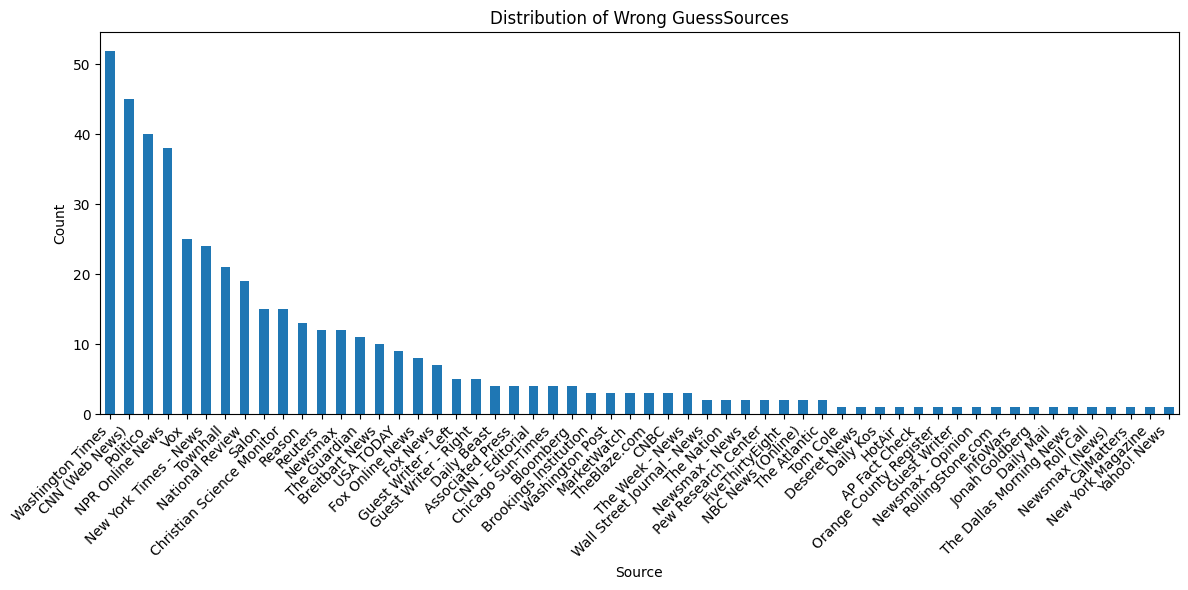

In [68]:
sources_analysis['source']
# Count the occurrences of each source
source_counts = sources_analysis['source'].value_counts()

# Create a bar plot
plt.figure(figsize=(12, 6))
source_counts.plot(kind='bar')

# Customize the plot
plt.title('Distribution of Wrong Guess''Sources')
plt.xlabel('Source')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

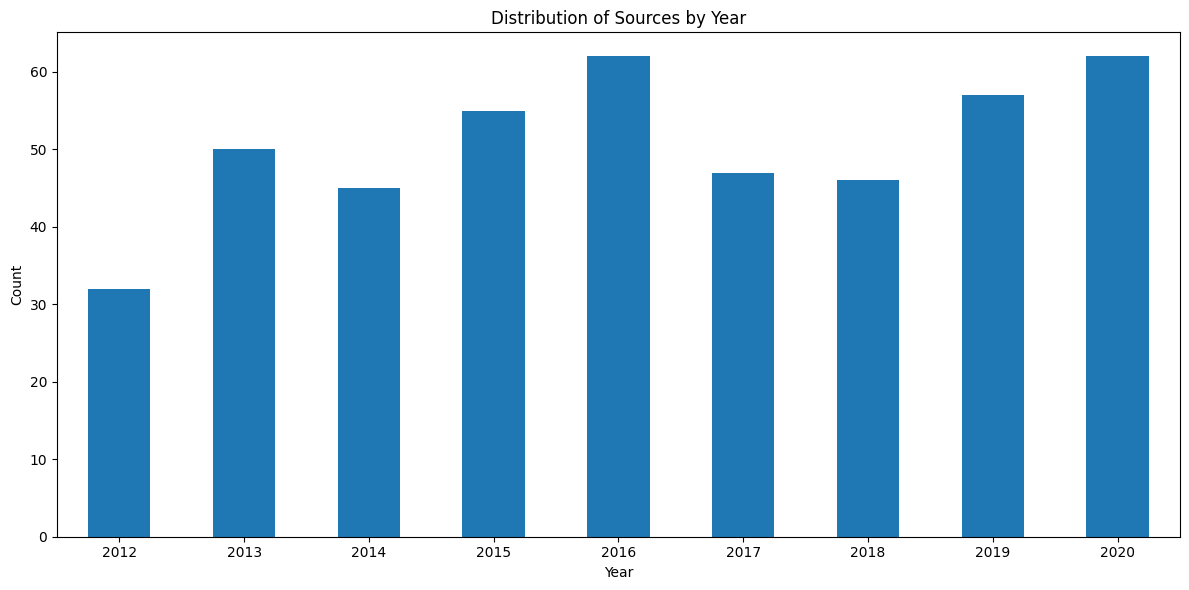

In [69]:
# Convert 'date' to datetime if it's not already
sources_analysis['date'] = pd.to_datetime(sources_analysis['date'])

# Extract year from the date
sources_analysis['year'] = sources_analysis['date'].dt.year

# Count occurrences of each year
year_counts = sources_analysis['year'].value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(12, 6))
year_counts.plot(kind='bar')

# Customize the plot
plt.title('Distribution of Sources by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=0)  # No rotation for years
plt.tight_layout()

# Show the plot
plt.show()

In [71]:
for i in wrong_guesses[:50]:
  decoded_text = distillroberta_nli_tokenizer.decode(x_test['input_ids'][i], skip_special_tokens=True)

  print("Input text:")
  print(decoded_text)
  print("True label:")
  print(y_test.iloc[i])
  print("Predicted label:")
  print(predictions_model.numpy()[i])

  print("-" * 50)


Input text:
the stage set battle group walmart wmt the unionbacked group walmart expects thousand worker participate protest planned week. employee ask country largest employer end call retaliation speaking better pay, fair schedule affordable health care. such retaliation include shuffling around shifts, cutting hour moving around departments. walmart say protester make handful 1.3 million workforce. in effort stop them, walmart filed complaint last week national labor relation board, claiming united food commercial worker union subsidiary known ourwalmart unlawfully organized picket line demonstration past six months. retailer said action disrupted business, worker ongoing action violate national labor relation act, prohibits picketing period 30 day without filing petition form union. related: suck work black friday representative federal agency currently holding talk walmart headquarters bentonville, arkansas, complaint. nancy cleeland, spokeswoman agency, said email decision agency

In [72]:
sources_analysis.to_csv('distill_roberta_fine_tuning_wrong guess(7.21.24).csv', index=False)